# Adventure Works
## Análise Exploratória

[Rafael Gurgel](https://github.com/rurgel)

### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
from pathlib import Path
from numpy import datetime64
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import itertools

import functions
from config.core import config, DATAPATH

### Obtenção e carregamento da base de dados

O desafio solicita a análise utilizando a biblioteca Pandas.

Entretanto para analisar uma maior quantidade de dados e variáveis, buscou-se a fonte da base original, na Microsoft. Esses dados foram preparados para o uso em um banco SQL. Sendo assim, foi preciso criar um script adicional para carregar os dados no pandas.

Alternativamente, é possível criar uma infraestrutura de banco de dados, carregando um servidor no container e populando o banco de dados. Entretanto isso diverge do objetivo da análise exploratória dos dados. 

<br>
As tabelas serão carregadas separadamente em diferentes variáveis por questões de eficiência de memória. Apenas as informações necessárias serão combinadas ao gerar visualizações.

In [2]:
SalesOrderHeader = functions.get_table('SalesOrderHeader', DATAPATH)
SalesOrderDetail = functions.get_table('SalesOrderDetail', DATAPATH)
SalesReasonHeader= functions.get_table('SalesOrderHeaderSalesReason', DATAPATH, usecols=[0,1])
SalesReason = functions.get_table('SalesReason', DATAPATH, usecols=[0,1,2]).rename(columns={'Name':'Reason'})

Product = functions.get_table('Product', DATAPATH)
ProductSubcategory = functions.get_table('ProductSubcategory', DATAPATH)
ProductCategory = functions.get_table('ProductCategory', DATAPATH)

Address = functions.get_table('Address', DATAPATH, usecols=[0,1,2,3,4,5])
StateProvince = functions.get_table('StateProvince', DATAPATH, encoding='utf-16', usecols=['StateProvinceID', 'StateProvinceCode', 'CountryRegionCode', 'Name', 'TerritoryID']).rename(columns={'Name':'StateProvince'})
CountryRegion = functions.get_table('CountryRegion', DATAPATH, encoding='utf-16', usecols=['CountryRegionCode', 'Name']).rename(columns={'Name': 'Country'})

SpecialOfferProduct = functions.get_table('SpecialOfferProduct', DATAPATH, usecols=[0,1])
SpecialOffer = functions.get_table('SpecialOffer', DATAPATH, usecols=[0,1,2,3,4])

### Avaliação da consistência da base de dados

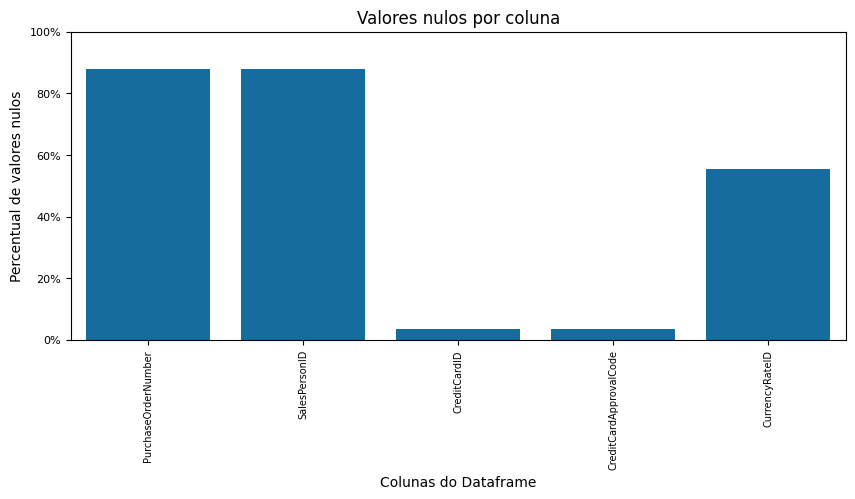

In [3]:
functions.plot_null(SalesOrderHeader, hue=None, filter=True)

Ajustando os tipos de dados. Ao converter o tipo da columna Comment para string, os valores nulos serão preenchidos pela string vazia.

In [4]:
functions.summarize_dtypes(SalesOrderHeader)
functions.summarize_dtypes(SalesOrderDetail)

Tipo dos Dados  Quantidade
         int64           8
        object           6
datetime64[ns]           4
       float64           4
         Int64           3
          bool           1

Tipo dos Dados  Quantidade
         int64           4
       float64           3
        object           2
         Int64           1
datetime64[ns]           1



In [5]:
functions.summarize_dtypes(Product)
functions.summarize_dtypes(ProductCategory)
functions.summarize_dtypes(ProductSubcategory)

Tipo dos Dados  Quantidade
        object          12
         int64           5
       float64           5
         Int64           2
datetime64[ns]           1

Tipo dos Dados  Quantidade
        object           2
         Int64           1
datetime64[ns]           1

Tipo dos Dados  Quantidade
         Int64           2
        object           2
datetime64[ns]           1



### Indicadores básicos

#### Vendas

In [6]:
functions.show_pandas(
    SalesOrderHeader
        .groupby(pd.Grouper(key='OrderDate', freq='Y'))
        [['SubTotal', 'TaxAmt', 'Freight', 'TotalDue']]
        .sum())

,SubTotal,TaxAmt,Freight,TotalDue
OrderDate,,,,
2011,"$12.641.672,21","$1.153.544,57","$360.482,74","$14.155.699,53"
2012,"$33.524.301,33","$3.162.970,58","$988.428,40","$37.675.700,31"
2013,"$43.622.479,05","$4.071.168,46","$1.272.240,45","$48.965.887,96"
2014,"$20.057.928,81","$1.799.290,84","$562.278,66","$22.419.498,32"


##### Total de pedidos ao longo do tempo

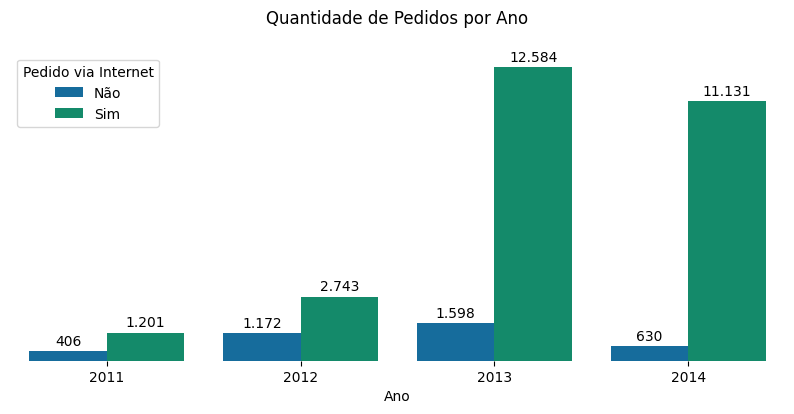

In [7]:
plt.figure(figsize=(10,4))
ax = sns.barplot(data=SalesOrderHeader
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['SalesOrderID']]\
                .count()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='SalesOrderID', hue='OnlineOrderFlag')
ax.set(title='Quantidade de Pedidos por Ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], padding=2)
ax.bar_label(ax.containers[1], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()


##### Total de itens vendidos anualmente

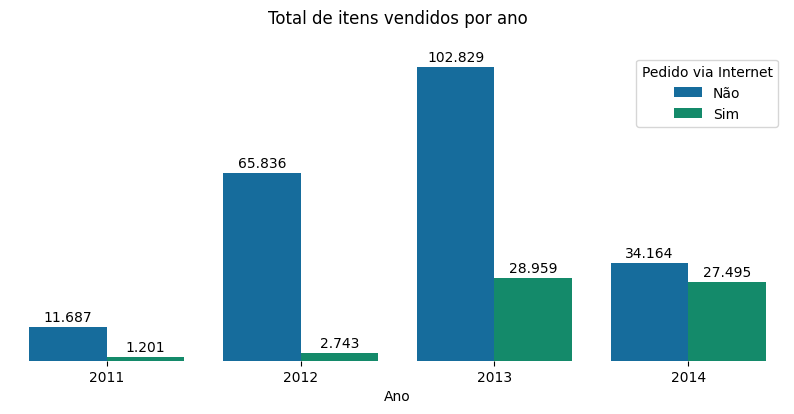

In [8]:
plt.figure(figsize=(10,4))

ax = sns.barplot(data=pd.merge(SalesOrderDetail[['SalesOrderID', 'OrderQty']], 
                               SalesOrderHeader[['SalesOrderID', 'OrderDate', 'OnlineOrderFlag']],
                              on='SalesOrderID', how='left')
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['OrderQty']]\
                .sum()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='OrderQty', hue='OnlineOrderFlag')
ax.set(title='Total de itens vendidos por ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], padding=2)
ax.bar_label(ax.containers[1], labels=[f'{x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()

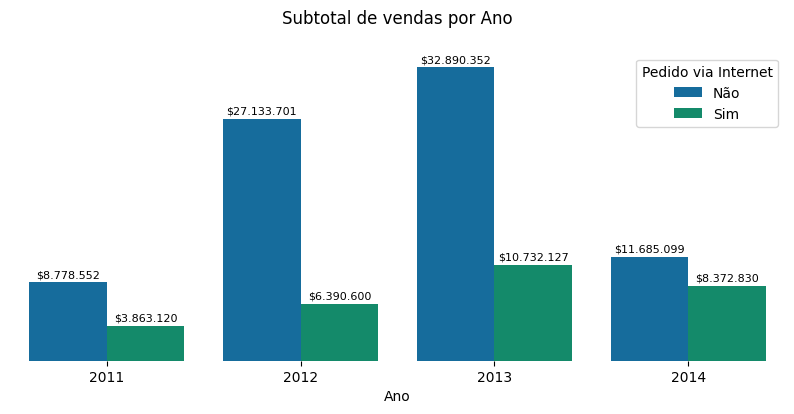

In [9]:
plt.figure(figsize=(10,4))
ax = sns.barplot(data=SalesOrderHeader
                .groupby([pd.Grouper(key='OrderDate', freq='Y'), 'OnlineOrderFlag'])[['SubTotal']]\
                .sum()
                .reset_index()
                .assign(OrderDate=lambda x: x['OrderDate'].dt.year)
                .assign(OnlineOrderFlag=lambda x: x['OnlineOrderFlag'].map({False: 'Não', True: 'Sim'})),
            x='OrderDate', y='SubTotal', hue='OnlineOrderFlag')
ax.set(title='Subtotal de vendas por Ano\n', xlabel='Ano')
ax.bar_label(ax.containers[0], labels=[f'${x:,.0f}'.replace(',','.') \
        for x in ax.containers[0].datavalues], fontsize=8, padding=2)
ax.bar_label(ax.containers[1], labels=[f'${x:,.0f}'.replace(',','.') \
        for x in ax.containers[1].datavalues], fontsize=8, padding=2)
plt.gca().axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(title='Pedido via Internet')
plt.show()


#### Portifólio de produtos

##### Categorias de Produtos

In [10]:
SalesOrderDetail[['ProductID', 'OrderQty', 'LineTotal']].set_index('ProductID')\
    .join(Product[['ProductID', 'ProductSubcategoryID']].set_index('ProductID'))\
    .reset_index().set_index('ProductSubcategoryID')\
    .rename(columns={'Name':'ProductName'})\
    .join(ProductSubcategory[['ProductSubcategoryID', 'Name', 'ProductCategoryID']].set_index('ProductSubcategoryID'))\
    .rename(columns={'Name':'Subcategory'})\
    .reset_index(drop=True).set_index('ProductCategoryID')\
    .join(ProductCategory[['ProductCategoryID', 'Name']].set_index('ProductCategoryID'))\
    .rename(columns={'Name':'Category'})\
    .reset_index(drop=True)\
    .groupby(['Category', 'Subcategory'])\
    .agg({'ProductID': 'nunique', 'OrderQty': 'sum', 'LineTotal': 'sum'})\
    .rename(columns={'ProductID': 'Itens Distintos', 
                     'OrderQty': 'Itens Vendidos', 
                     'LineTotal': 'Valor das Vendas'})\
    .style\
    .background_gradient(subset=['Itens Distintos', 'Itens Vendidos'], cmap='Blues')\
    .format('{0:,.0f}', subset=['Itens Vendidos'], thousands='.', decimal=',')\
    .format('$ {0:,.0f}', subset=['Valor das Vendas'], thousands='.', decimal=',')\
    .bar(subset=['Valor das Vendas'], align='left', width=100, height=60, vmin=0, color='lightgreen')

#### Produtos mais vendidos

In [11]:
SalesOrderDetail[['ProductID', 'OrderQty', 'LineTotal']].set_index('ProductID')\
    .join(Product[['ProductID', 'Name']].set_index('ProductID'))\
    .rename(columns={'Name': 'Produto'})\
    .groupby('Produto')\
    .sum()\
    .sort_values('OrderQty', ascending=False)\
    .rename(columns={'OrderQty': 'Itens Vendidos', 'LineTotal': 'Valor das Vendas'})\
    .head(10)\
    .style\
        .format('${0:,.0f}', thousands='.', decimal=',', subset='Valor das Vendas')\
        .background_gradient(cmap='Greens', subset=['Valor das Vendas'])\
            .set_table_styles([
                    {'selector': 'th.col_heading',
                     'props': 'font-size: 1.25em;'},
                    {'selector': 'td',
                     'props': 'text-align:center; font-weight:bold;'},
                    {'selector': '.index_name',
                     'props': 'font-style:italic; text-align:center; font-weight:normal;font-size:1.3em;'},
                    {'selector': 'th',
                     'props': 'text-align:left;'},
                    {'selector': 'th:not(.col_heading):not(.index_name)',
                     'props': 'color:dimgray;font-size:1.1em;'},
                ], overwrite=False)

,Itens Vendidos,Valor das Vendas
Produto,,
AWC Logo Cap,8311,$51.229
Water Bottle - 30 oz.,6815,$28.654
"Sport-100 Helmet, Blue",6743,$165.407
"Long-Sleeve Logo Jersey, L",6592,$198.755
"Sport-100 Helmet, Black",6532,$160.870
"Sport-100 Helmet, Red",6266,$157.772
"Classic Vest, S",4247,$156.398
Patch Kit/8 Patches,3865,$8.233
"Short-Sleeve Classic Jersey, XL",3864,$129.146


##### Quais produtos mais comprados em conjunto em uma compra / por cliente

In [12]:
def produtos_conjunto(online=True):
    if online:
        tit='(Vendas Online)'
    else:
        tit = '(Vendas Físicas)'
    display(SalesOrderDetail[['SalesOrderID', 'ProductID']]\
        .merge(SalesOrderHeader[['SalesOrderID', 'OnlineOrderFlag']], on='SalesOrderID')\
        .query('OnlineOrderFlag == @online')\
        .assign(Different_Products=
                SalesOrderDetail[['SalesOrderID']]\
                    .groupby('SalesOrderID')['SalesOrderID']\
                    .transform('count'))\
        .query('Different_Products > 1')\
        .groupby('ProductID')\
        .agg({'SalesOrderID': 'count'})\
        .reset_index()\
        .sort_values('SalesOrderID', ascending=False)\
        .head(10)\
        .merge(Product[['ProductID', 'Name', 'ListPrice']])\
        .rename(columns={'Name':'Produto', 'SalesOrderID': 
                         'Quantidade Vendida', 'ListPrice': 'Preço Unitário'})\
        .set_index('Produto')\
        .drop('ProductID', axis=1)\
        .style\
        .set_caption('Produtos mais vendidos em combinação com outro '+tit)\
        .format('$ {0:,.2f}', thousands='.', decimal=',', 
                subset='Preço Unitário')\
        .set_table_styles([{'selector': 'th.col_heading',
                            'props': 'font-size: 1.25em;'},
                           {'selector': 'td',
                            'props': 'text-align:center; font-weight:bold;'},
                           {'selector': 'caption',
                            'props': 'font-size: 1.5em;font-weight: bold;'},
                           {'selector': 'th',
                            'props': 'text-align:left;'},
                           {'selector': '.index_name',
                            'props': 'font-style:italic; text-align:center;font-weight:normal;font-size:1.3em;'},
                           {'selector': 'th:not(.col_heading):not(.index_name)',
                            'props': 'color:dimgray;font-size:1.1em;'},
                        ], overwrite=False))

produtos_conjunto(online=True)
print('')
produtos_conjunto(online=False)

,Quantidade Vendida,Preço Unitário
Produto,,
Water Bottle - 30 oz.,3924,"$ 4,99"
Patch Kit/8 Patches,3052,"$ 2,29"
Mountain Tire Tube,2959,"$ 4,99"
Road Tire Tube,2281,"$ 3,99"
"Sport-100 Helmet, Red",2165,"$ 34,99"
"Sport-100 Helmet, Blue",2069,"$ 34,99"
"Sport-100 Helmet, Black",2026,"$ 34,99"
AWC Logo Cap,2011,"$ 8,99"
Fender Set - Mountain,1960,"$ 21,98"


,Quantidade Vendida,Preço Unitário
Produto,,
AWC Logo Cap,1191,"$ 8,99"
"Long-Sleeve Logo Jersey, L",1181,"$ 49,99"
"Sport-100 Helmet, Blue",959,"$ 34,99"
"Sport-100 Helmet, Black",921,"$ 34,99"
"Sport-100 Helmet, Red",851,"$ 34,99"
"Long-Sleeve Logo Jersey, M",773,"$ 49,99"
"Mountain-200 Black, 38",663,"$ 2.294,99"
"Long-Sleeve Logo Jersey, XL",659,"$ 49,99"
"Road-650 Red, 60",619,"$ 782,99"


In [13]:
def combinacao_produtos(online=True):
    if online:
        tit='(Vendas Online)'
    else:
        tit = '(Vendas Físicas)'
    display(SalesOrderDetail[['SalesOrderID', 'ProductID']]\
        .merge(SalesOrderHeader[['SalesOrderID', 'OnlineOrderFlag']],
               on='SalesOrderID')\
        .query('OnlineOrderFlag == @online')\
        .groupby('SalesOrderID')\
        .agg({'ProductID': lambda x: list(itertools.combinations(x, 2))})\
        .explode(column='ProductID')\
        .reset_index(drop=True)\
        .dropna()\
        .value_counts()\
        .head(10)\
        .reset_index()\
        .explode('ProductID')\
        .rename(columns={0:'Compras'})\
        .reset_index()\
        .merge(Product[['ProductID', 'Name', 'ListPrice']])\
        .sort_values('ListPrice')\
        .groupby('index')\
        .agg(Produto1=('Name', 'last'), 
             Produto2=('Name', 'first'), 
             Compras=('Compras', 'first'))\
        .style\
        .hide(axis='index')\
        .set_caption('Combinação de Produtos '+tit)\
        .set_properties(**{'text-align': 'left'}, 
                        subset=['Produto1', 'Produto2'])\
        .set_table_styles([{'selector': 'th.col_heading',
                            'props': 'font-size: 1.25em;text-align:left;'},
                           {'selector': 'caption',
                            'props': 'font-size: 1.5em;font-weight: bold;'}
                        ], overwrite=False))
    
combinacao_produtos(online=True)
print('')
combinacao_produtos(online=False)

Produto1,Produto2,Compras
Mountain Bottle Cage,Water Bottle - 30 oz.,1267
Road Bottle Cage,Water Bottle - 30 oz.,932
Mountain Tire Tube,Patch Kit/8 Patches,785
Touring Tire,Touring Tire Tube,605
Road Tire Tube,Patch Kit/8 Patches,589
Road Bottle Cage,Water Bottle - 30 oz.,589
HL Mountain Tire,Mountain Tire Tube,556
AWC Logo Cap,Water Bottle - 30 oz.,522
ML Mountain Tire,Mountain Tire Tube,459
"Sport-100 Helmet, Black",Mountain Tire Tube,453


Produto1,Produto2,Compras
"Long-Sleeve Logo Jersey, L",AWC Logo Cap,593
"Long-Sleeve Logo Jersey, L",AWC Logo Cap,501
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Blue",464
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Black",463
"Long-Sleeve Logo Jersey, L","Sport-100 Helmet, Red",458
"Sport-100 Helmet, Blue","Sport-100 Helmet, Red",448
"Sport-100 Helmet, Black",AWC Logo Cap,440
"Sport-100 Helmet, Blue","Sport-100 Helmet, Black",436
"Sport-100 Helmet, Blue",AWC Logo Cap,432
"Sport-100 Helmet, Red",AWC Logo Cap,425


### Destino das compras

In [14]:
def list_places(online = True, min_orders=100):
     if online:
        tit='(Vendas Online)'
     else:
         tit = '(Vendas Físicas)'
     display(SalesOrderHeader[['SalesOrderID', 
                               'OnlineOrderFlag', 
                               'ShipToAddressID', 
                               'SubTotal', 
                               'Freight']]\
          .query('OnlineOrderFlag == @online')\
          .merge(Address, left_on='ShipToAddressID', right_on='AddressID')\
          .merge(StateProvince, on='StateProvinceID')\
          .merge(CountryRegion, on='CountryRegionCode')\
          .rename(columns={'StateProvince': 'Estado\Província',
                           'Country': 'País'})\
          .groupby(['Estado\Província', 'País'])\
          .agg(Orders=('SalesOrderID', 'count'),
               AvgFreight=('Freight', 'mean'),
               AvgSubTotal=('SubTotal', 'mean'),
               TotalSales=('SubTotal', 'sum'))\
          .query('Orders >= @min_orders')\
          .sort_values('AvgSubTotal', ascending=False)\
          .rename(columns={'Orders': 'Pedidos', 'AvgFreight': 'Valor Médio do Frete',
                           'AvgSubTotal': 'Valor Médio dos Pedidos', 'TotalSales': 'Total das Vendas'})\
          .style\
          .set_caption('Vendas '+tit)\
          .format('$ {0:,.0f}', thousands='.', decimal=',', 
                subset=['Total das Vendas'])\
          .format('$ {0:,.2f}', thousands='.', decimal=',', 
                subset=['Valor Médio do Frete', 'Valor Médio dos Pedidos'])\
          .background_gradient(cmap='Blues', subset=['Pedidos'])\
          .bar(subset=['Total das Vendas', 'Valor Médio dos Pedidos'], color='lightgreen', align='left', width=90, height=60)\
          .set_table_styles([{'selector': 'th.col_heading',
                            'props': 'font-size: 1.25em;'},
                           {'selector': 'td',
                            'props': 'text-align:center; font-weight:bold;'},
                           {'selector': 'caption',
                            'props': 'font-size: 1.5em;font-weight: bold;'},
                           {'selector': 'th',
                            'props': 'text-align:left;'},
                           {'selector': '.index_name',
                            'props': 'font-style:italic; text-align:center;font-weight:normal;font-size:1.3em;'},
                           {'selector': 'th:not(.col_heading):not(.index_name)',
                            'props': 'color:dimgray;font-size:1.1em;'},
                        ], overwrite=False)
     )
          
list_places(online=True, min_orders=100)
print('')
list_places(online=False, min_orders=100)

,,Pedidos,Valor Médio do Frete,Valor Médio dos Pedidos,Total das Vendas
Estado\Província,País,,,,
Queensland,Australia,1457,"$ 34,12","$ 1.364,73",$ 1.988.415
South Australia,Australia,455,"$ 33,97","$ 1.358,80",$ 618.256
Victoria,Australia,1686,"$ 33,81","$ 1.352,26",$ 2.279.906
New South Wales,Australia,2923,"$ 33,65","$ 1.346,04",$ 3.934.486
Essonne,France,225,"$ 31,03","$ 1.241,32",$ 279.297
Hessen,Germany,538,"$ 30,77","$ 1.230,68",$ 662.103
Bayern,Germany,328,"$ 30,49","$ 1.219,41",$ 399.967
Tasmania,Australia,197,"$ 30,45","$ 1.217,96",$ 239.938
Yveline,France,224,"$ 29,98","$ 1.199,40",$ 268.665


,,Pedidos,Valor Médio do Frete,Valor Médio dos Pedidos,Total das Vendas
Estado\Província,País,,,,
British Columbia,Canada,113,"$ 922,50","$ 30.262,21",$ 3.419.630
Texas,United States,248,"$ 810,67","$ 26.833,14",$ 6.654.619
Washington,United States,288,"$ 732,91","$ 24.148,32",$ 6.954.715
California,United States,418,"$ 716,18","$ 23.359,50",$ 9.764.271
England,United Kingdom,188,"$ 693,01","$ 22.760,69",$ 4.279.009
Quebec,Canada,146,"$ 620,86","$ 20.492,23",$ 2.991.865
Ontario,Canada,338,"$ 557,15","$ 18.281,62",$ 6.179.188
Florida,United States,154,"$ 452,63","$ 14.934,34",$ 2.299.889
Michigan,United States,104,"$ 423,39","$ 13.921,94",$ 1.447.882


### Análise Estratégica

O valor (preço ou promoção) é o fator determinante para a realização de uma venda. Em segundo lugar o cliente preza por fabricantes/qualidade do produto.

Com isso, vamos analisar o efeito das promoções

In [15]:
SalesReasonHeader.merge(SalesReason, on='SalesReasonID')\
    .groupby('Reason')\
    .agg({'SalesOrderID': 'count'})\
    .sort_values('SalesOrderID', ascending=False)\
    .style\
    .bar(subset=['SalesOrderID'],
         color='lightgreen', 
         align='left', width=90, height=60, vmin=0)

,SalesOrderID
Reason,
Price,17473
On Promotion,3515
Manufacturer,1746
Quality,1551
Other,1395
Review,1245
Television Advertisement,722


In [16]:
SalesOrderDetail[['OrderQty', 'ProductID', 'SpecialOfferID', 'LineTotal']]\
    .merge(SpecialOfferProduct, on=['SpecialOfferID', 'ProductID'])\
    .merge(SpecialOffer, on='SpecialOfferID')\
    .rename(columns={'Type': 'Tipo de Desconto',
                     'Description': 'Ocasião'})\
    .groupby(['Tipo de Desconto', 'Ocasião'])\
    .agg({'OrderQty': 'sum', 'DiscountPct': 'mean', 'LineTotal': 'sum'})\
    .query('Ocasião not in "No Discount"')\
    .rename(columns={'OrderQty': 'Quantidade',
                     'DiscountPct': 'Desconto Médio',
                     'LineTotal': 'Total das Vendas'})\
    .style\
    .set_caption('Vendas Promocionais')\
    .format('$ {0:,.0f}', thousands='.', decimal=',', subset=['Total das Vendas'])\
    .format('{0:.0%}', thousands='.', decimal=',', subset=['Desconto Médio'])\
    .background_gradient(cmap='Blues', subset=['Quantidade'])\
    .bar(subset=['Total das Vendas'], color='lightgreen', align='left', width=90, height=60)\
    .text_gradient(subset=['Desconto Médio'], cmap='Reds', low=0.2, high=0.4)\
    .set_table_styles([{'selector': 'th.col_heading',
                          'props': 'font-size: 1.25em;'},
                         {'selector': 'td',
                          'props': 'text-align:center; font-weight:bold;'},
                         {'selector': 'caption',
                          'props': 'font-size: 1.5em;font-weight: bold;'},
                         {'selector': 'th',
                          'props': 'text-align:left;'},
                         {'selector': '.index_name',
                          'props': 'font-style:italic; text-align:center;font-weight:normal;font-size:1.3em;'},
                         {'selector': 'th:not(.col_heading):not(.index_name)',
                          'props': 'color:dimgray;font-size:1.1em;'},
                         ], overwrite=False)

In [17]:
SalesOrderDetail[['OrderQty', 'ProductID', 'SpecialOfferID',  'LineTotal']]\
    .merge(SpecialOfferProduct, on=['SpecialOfferID', 'ProductID'])\
    .merge(SpecialOffer, on='SpecialOfferID')\
    .groupby(['ProductID', 'Description'])\
    .agg({'OrderQty': 'sum', 'DiscountPct': 'mean',  'LineTotal': 'sum'})\
    .assign(Preco_Medio=lambda x: x['LineTotal']/x['OrderQty'])\
    .drop(columns=['LineTotal'])\
    .reset_index()\
    .assign(Pct= lambda df: df.groupby('ProductID')['OrderQty'].transform(lambda x: x/x.sum()))\
    .query('Description not in "No Discount"')\
    .sort_values('Pct', ascending=False)\
    .merge(Product[['ProductID', 'Name']], on='ProductID')\
    .drop('ProductID', axis=1)\
    .query('Pct>=0.2')\
    .rename(columns={'Name': 'Produto', 'OrderQty': 'Quantidade', 
                     'DiscountPct': 'Desconto Médio', 
                     'Pct': 'Percentual das Vendas do Produto', 
                     'Description': 'Promoção', 'Preco_Medio': 'Preço Médio'})\
    .sort_values(['Promoção', 'Produto'])\
    .set_index(['Promoção', 'Produto'])\
    .style\
    .set_caption('Itens Promocionais mais vendidos')\
    .format('$ {0:,.2f}', thousands='.', decimal=',', subset=['Preço Médio'])\
    .format('{0:.0%}', thousands='.', decimal=',', subset=['Desconto Médio', 'Percentual das Vendas do Produto'])\
    .background_gradient(cmap='Blues', subset=['Quantidade'])\
    .bar(subset=['Percentual das Vendas do Produto'], color='lightgreen', align='left', width=90, height=60, vmin=0)\
    .text_gradient(subset=['Desconto Médio'], cmap='Reds', low=0.2, high=0.4)\
    .set_table_styles([{'selector': 'th.col_heading',
                          'props': 'font-size: 1.25em;'},
                         {'selector': 'td',
                          'props': 'text-align:center; font-weight:bold;'},
                         {'selector': 'caption',
                          'props': 'font-size: 1.5em;font-weight: bold;'},
                         {'selector': 'th',
                          'props': 'text-align:left;'},
                         {'selector': '.index_name',
                          'props': 'font-style:italic; text-align:center;font-weight:normal;font-size:1.3em;'},
                         {'selector': 'th:not(.col_heading):not(.index_name)',
                          'props': 'color:dimgray;font-size:1.1em;'},
                         ], overwrite=False)
